# Functions

WNM:  construct affinity matrix of size n x m (local scaling)  
WNM2:  construct affinity matrix of size n x m (global scaling)

COL:  clustering using k-means, return the coloring  
SHOW:  show scatter in 2d  
SHOW3:  showing scatter in 3d

In [1]:
%pylab inline
from scipy import sparse, stats
from scipy.io import loadmat
from scipy.spatial.distance import cdist
from scipy.sparse.linalg import svds,eigs
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

Populating the interactive namespace from numpy and matplotlib


In [2]:
def WNM(A,B,n,s):
    
    # dense distance matrix
    Dist     = cdist(A,B)

    # local scaling
    Distsort = sort(Dist, axis=0)
    tmp      = Distsort[s+1,:]
    tmp[argwhere(tmp==0)] = 1e-5
    sigmasm  = diag(1/tmp)             
    
    Distsort = sort(Dist, axis=1)
    tmp      = Distsort[:,s+1]
    tmp[argwhere(tmp==0)] = 1e-5
    sigmabg  = sparse.dia_matrix((1/tmp,0), shape=(n,n)) 

    return exp( -sigmabg.dot(Dist*Dist).dot(sigmasm) )

In [3]:
def WNM2(A,B,n,sigma):
    
    # dense distance matrix
    Dist     = cdist(A,B)

    #sigma = percentile(Dist,1)

    return exp( -(Dist*Dist)/sigma )

In [4]:
def COL(emb,n,cluster):

    kmeans = KMeans(cluster)
    kmeans = kmeans.fit(emb)
    label  = array(kmeans.predict(emb)).reshape(n,1)
    
    cmap = cm.rainbow
    norm = Normalize(1, cluster)
    col  = cmap(norm(label+1)).reshape(n,4)
    
    return col

In [5]:
def SHOW(X,Y,col,tit='output',siz=2,save=0):
    plt.scatter(X, Y, s=siz, c=col)
    
    plt.title(tit)
    plt.gcf().set_size_inches(6,6)
    if save: plt.savefig('Result/' + tit + '.png')
    plt.show()

In [6]:
def SHOW3(X,Y,Z,col,tit='output',siz=2,save=0):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(X, Y, Z, s=siz, c=col)
    
    plt.title(tit)
    plt.gcf().set_size_inches(6,6)
    if save: plt.savefig('Result/' + tit + '.png')
    plt.show()

# Variables

X: data points,  size n

Y: landmark set, size m


dim: embedded dimension

s: local scaling parameter


cluster: cluster number 

In [7]:
X       = loadmat('Data/3d4000.mat')['A']
n       = X.shape[0]
beta    = .5
m       = round(pow(n,beta))
subi    = range(int(n/m)-1,n,int(n/m))    # i = sort(permutation(n)[:m])

Y       = X[subi,:]

In [8]:
dim     = 10
s       = 7
cluster = 5

In [9]:
print('n = ',n,'\nm = ',m)

n =  4000 
m =  63


# Data set

/Users/joyax/opt/anaconda3/envs/mine/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  This is separate from the ipykernel package so we can avoid doing imports until


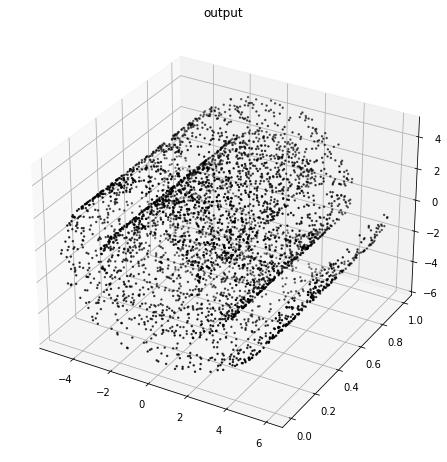

In [10]:
SHOW3(X[:,0],X[:,1],X[:,2],'k')

# Diffusion Map

In [11]:
def DM(A,n,s,dim):

    ### construct W (affinity matrix)
    W   = WNM(A,A,n,s)
    
    ### construct D^{-1/2} (diagonal matrix with row sum of W on its diagonal)
    tmp = sqrt(sum(W,axis=1))
    D   = diag(1/tmp)
    

    ### construct Q (Q is similar to the probability matrix)
    Q   = D.dot(W).dot(D)


    ### find Q's (and thus the probability mat's) eigval and eigvec
    EIG,U = eigs(Q,dim+1)
    
    EIG   = EIG.real
    L     = diag(EIG)
    U     = U.real
    
    
    ### construct diffusion map
    EMB   = D.dot(U).dot(L)

    return EMB, EIG

In [12]:
%%time
# sigmadm = 0.5
EMBdm, EIGdm = DM(X,n,s,dim)

CPU times: user 33.4 s, sys: 3.28 s, total: 36.7 s
Wall time: 8.06 s


/Users/joyax/opt/anaconda3/envs/mine/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  This is separate from the ipykernel package so we can avoid doing imports until


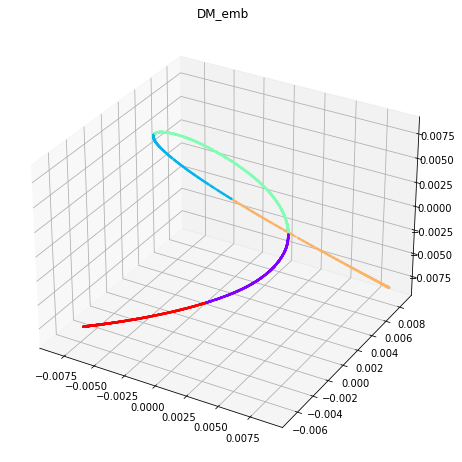

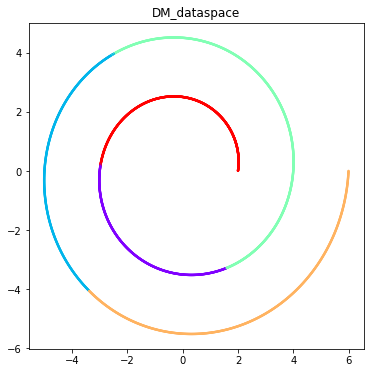

In [13]:
COLdm = COL(EMBdm[:,:3],n,cluster)

# print('eigenvalues: ',eigdm,'\n')

SHOW3(EMBdm[:,3],EMBdm[:,1],EMBdm[:,2],COLdm,save=1,tit='DM_emb')

SHOW(X[:,0],X[:,2],COLdm,save=1,tit='DM_dataspace')

# ROSELAND

In [14]:
def roseland(A,B,n,s,dim):
    
    ### construct W (affinity matrix)
    W    = WNM(A,B,n,s)
    
    
    ### construct D (diagonal matrix with row sum of WW^T on its diagonal)
    tmp1 = sum(W, axis=0)
    tmp2 = W.dot(tmp1)
    D    = diag(1/pow(tmp2, .5))
    
    
    ### construct Q (Q is similar to the probability matrix)
    Q    = D.dot(W)

    
    ### find Q's (and thus the probability mat's) eigval and eigvec
    U,EIG,V = svds(Q,dim+1)
    
    L = EIG[::-1]
    L = diag(L*L)
    U = U[:,::-1]


    ### construct diffusion map
    EMB = D.dot(U).dot(L)
    
    
    return EMB, EIG[::-1]

In [15]:
%%time
# sigmaros = 0.5
EMBros, EIGros = roseland(X,Y,n,s,dim)

CPU times: user 552 ms, sys: 158 ms, total: 711 ms
Wall time: 168 ms


/Users/joyax/opt/anaconda3/envs/mine/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  This is separate from the ipykernel package so we can avoid doing imports until


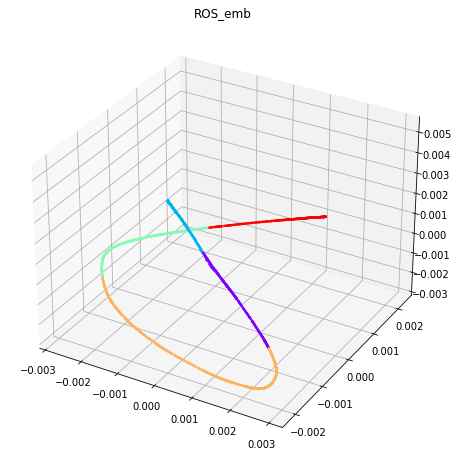

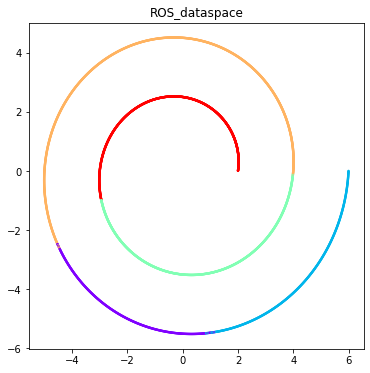

In [16]:
COLros = COL(EMBros[:,:3],n,cluster)

# print('eigenvalues: ',eigdm,'\n')

SHOW3(EMBros[:,3],EMBros[:,1],EMBros[:,2],COLros,save=1,tit='ROS_emb')

SHOW(X[:,0],X[:,2],COLros,save=1,tit='ROS_dataspace')

# HKC

In [17]:
def HKC(A,B,n,s,dim):
        
    W = WNM(A,B,n,s)
    D = diag(1/sum(W,axis=1))
    
    Q = D.dot(W)
    A = (Q.transpose()).dot(Q)
    
    EIG,U = eigs(A,dim+1)
    
    EIG = EIG.real
    U   = U.real
    L   = diag(1/sqrt(EIG))
    
    EMB = Q.dot(U).dot(L)

    return EMB, EIG

In [18]:
%%time
# sigmahkc       = 0.5
EMBhkc, EIGhkc = HKC(X,Y,n,s,dim)

CPU times: user 325 ms, sys: 86.6 ms, total: 412 ms
Wall time: 99.3 ms


/Users/joyax/opt/anaconda3/envs/mine/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  This is separate from the ipykernel package so we can avoid doing imports until


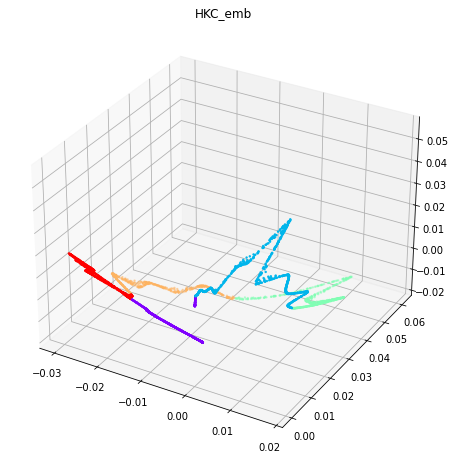

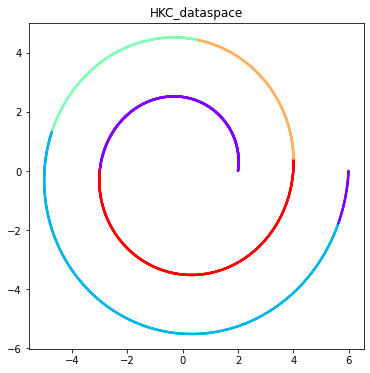

In [19]:
COLhkc = COL(EMBhkc[:,1:4],n,cluster)

SHOW3(EMBhkc[:,3],EMBhkc[:,1],EMBhkc[:,2],COLhkc,save=1,tit='HKC_emb')
SHOW(X[:,0],X[:,2],COLhkc,save=1,tit='HKC_dataspace')

# Nystrom

In [25]:
def nystrom2(A,B,n,s,dim,subi):

    ### construct W (n*m affinity matrix)
    W   = WNM(A,B,n,s)
    Wsm = W[subi,:]
    
    ### construct Ds
    dat = array(1/sqrt(sum(W,axis=1)))
    D   = sparse.csr_matrix((dat,arange(n),arange(n+1)), shape=(n,n))
    Dsm = diag(dat[subi])
    
    ### construct Q
    Qsm = Dsm.dot(Wsm).dot(Dsm)
    
    ### find Qsm's eigval and eigvec
    EIG,U = eigs(Qsm,dim+1)
    
    EIG   = EIG.real
    L     = diag(1/EIG)
    U     = U.real
    
    UU    = Dsm.dot(U)
    
    ### extension
    EMB = D.dot(W).dot(UU)
    
    return EMB, EIG, UU.dot(L)

In [32]:
%%time
EMBnys, EIGnys, EMBsm = nystrom2(X,Y,n,s,dim,subi)

CPU times: user 35.8 ms, sys: 32.1 ms, total: 67.9 ms
Wall time: 24.2 ms


/Users/joyax/opt/anaconda3/envs/mine/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  This is separate from the ipykernel package so we can avoid doing imports until


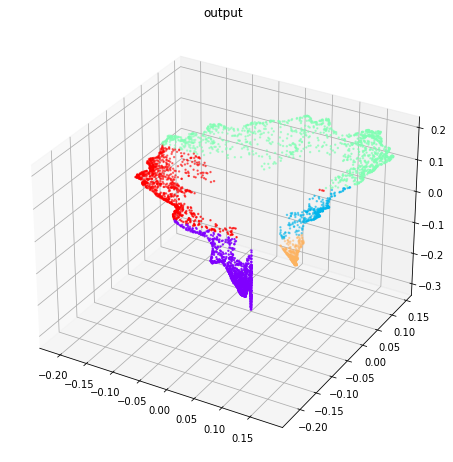

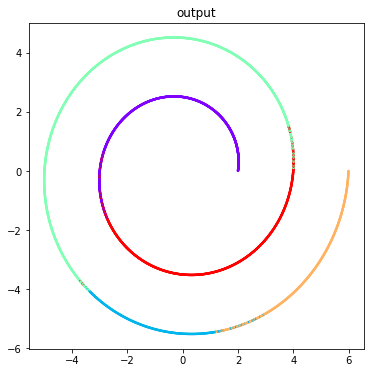

In [33]:
COLnys = COL(EMBnys[:,1:3],n,cluster)

# print('eigenvalues: ',eigdm,'\n')

SHOW3(EMBnys[:,3],EMBnys[:,1],EMBnys[:,2],COLnys)

SHOW(X[:,0],X[:,2],COLnys,save=1)

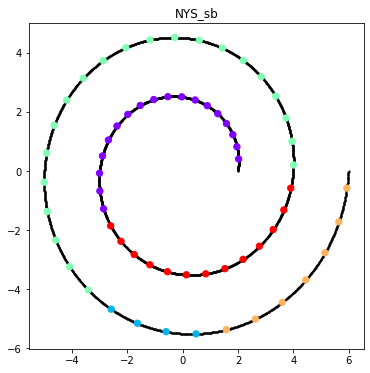

/Users/joyax/opt/anaconda3/envs/mine/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  This is separate from the ipykernel package so we can avoid doing imports until


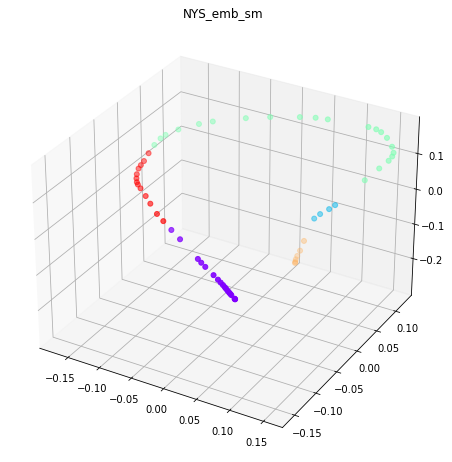

In [36]:
COLsm = COLnys[subi]

plt.scatter(X[:,0], X[:,2], s=1, c='black')
plt.scatter(X[subi,0], X[subi,2], s=40, c=COLsm)
plt.gcf().set_size_inches(6,6)
plt.savefig('Result/' + 'NYS_dataspace_sm' + '.png')    
plt.title('NYS_sb')
plt.show()

#plt.scatter(EMBsm[:,2], EMBsm[:,1], s=10, c=COLsm)
SHOW3(EMBsm[:,3],EMBsm[:,1],EMBsm[:,2],COLsm,siz=25,save=1,tit='NYS_emb_sm')

# Comparison

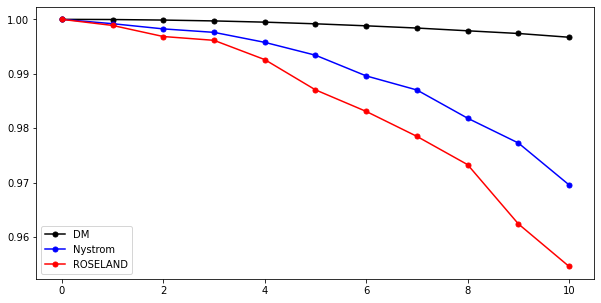

In [37]:
plt.plot(range(dim+1),EIGdm ,'k-',marker='.',markersize=10,label='DM')
plt.plot(range(dim+1),EIGnys,'b-',marker='.',markersize=10,label='Nystrom')
plt.plot(range(dim+1),EIGros,'r-',marker='.',markersize=10,label='ROSELAND')
#plt.plot(range(dim),1/sqrt(eighkc),'g-',marker='.',markersize=10,label='HKC')

plt.gcf().set_size_inches(10,5)
plt.legend()
#plt.savefig('Result/eigval.png')
plt.show()